## Loading corpus

In [1]:
import os
books = os.listdir('corpus')
print(books)

['prisoner_of_azkaban.txt', 'deathly_hallows.txt', 'goblet_of_fire.txt', 'half_blood_prince.txt', 'chamber_of_secrets.txt', 'order_of_the_phoenix.txt']


### Read all books

In [1]:
import re

def clean_text(text):

    text = re.sub(r"\.{2,}", " ", text)
    text = re.sub(r"(\. ){2,}", " ", text)
    text = re.sub(r"\-", "", text)
    text = re.sub(r'[^a-zA-Z\.\,\'\!\?]',' ',text)   
    text = re.sub(r'\s{2,}',' ',text)
    
    # words = text.split(" ")
    # words = [w.lower() if w.isupper() else w for w in words]
    # words = [w.lower() for w in words]
    # text = " ".join(words)
    
    return text.lower().strip()

def book2text(file):
    with open('corpus/' + file, 'r', encoding='latin-1"') as f:
        text_raw = f.readlines()
    
    print(len(text_raw))   
    text_all = " ".join(text_raw)
    print(len(text_all))
    # print(text_all[:1000])
    print()
    
    text_in_words = clean_text(text_all)
    return(text_in_words)

# text_in_words = book2text("chamber_of_secrets.txt")

# print(text_in_words[:1000])

Keras   
https://medium.com/@shivambansal36/language-modelling-text-generation-using-lstms-deep-learning-for-nlp-ed36b224b275 
https://machinelearningmastery.com/develop-word-based-neural-language-models-python-keras/   
PyTorch  
https://www.kaggle.com/alvations/gru-language-model

## Combine 6 books together

In [115]:
text_all = []
for file in books:
    text_1_book = book2text(file)
    text_all.append(text_1_book)

print(len(text_all))    
text_in_6books =  " ".join(text_all)
print(len(text_in_6books))

22
611252

37
1124269

37
1105224

30
984172

19
490821

38
1514978

6
5685410


In [116]:
text_in_6books[2000:5000]

"petunia, and their son, dudley, were harry's only living relatives. they were muggles, and they had a very medieval attitude toward magic. harry's dead parents, who had been a witch and wizard themselves, were never mentioned under the dursleys' roof for years, aunt petunia and uncle vernon had hoped that if they kept harry as downtrodden as possible, they would be able to squash the magic out of him. to their fury, they had been unsuccessful. these days they lived in terror of anyone finding out that harry had spent most of the last two years at hogwarts school of witchcraft and wizardry. the most they could do, however, was to lock away harry's spellbooks, wand, cauldron, and broomstick at the start of the summer break, and forbid him to talk to the neighbors. this separation from his spellbooks had been a real problem for harry, because his teachers at hogwarts had given him a lot of holiday work. one of the essays, a particularly nasty one about shrinking potions, was for harry's 

In [36]:
word_tokenize(text_in_6books[450:500])

['ok', 'a', 'history', 'of', 'magic', 'by', 'bathilda', 'bagshot', 'propped']

## Prepare training sequence

In [121]:
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize

input_len = 20
output_len = 20
n_words = 5000
tokenizer = Tokenizer(num_words=n_words, filters='')

def dataset_preparation(data, input_len, output_len):
    STEP = 1
    sentences = []
    next_words = []

    # corpus = data.split(" ") 
    corpus = word_tokenize(data)
    tokenizer.fit_on_texts(corpus)
    token_list = tokenizer.texts_to_sequences([corpus])[0]
    total_words = len(tokenizer.word_index) + 1
    
    # why dif??
    print(len(corpus))
    print(len(token_list))

    for i in range(0, len(token_list) - input_len - output_len, STEP):
        sentences.append(token_list[i: i + input_len])
        next_words.append(token_list[i + input_len])

    print('N training sequences:', len(sentences))
    print('N next words:', len(next_words))  
    
    return total_words, sentences, next_words


total_words, sentences, next_words = dataset_preparation(text_in_6books, input_len, output_len)
print('N total words:', total_words)  
# print(sentences[100])
# print(next_words[100])

1199012
1142680
N training sequences: 1142640
N next words: 1142640
N total words: 25274


In [122]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X = np.array(sentences)
Y = to_categorical(next_words, num_classes=n_words)
n_cat = Y.shape[1]

print(X.shape)
print(Y.shape)


# X_train, X_test, y_train, y_test = train_test_split(
#    X, Y, test_size=0.1, random_state=42)

# print(X_train.shape)
# print(y_train.shape)

(1142640, 20)
(1142640, 5000)


In [9]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

model = Sequential()
model.add(Embedding(n_words, 128, input_length=input_len))
# model.add(LSTM(128))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.2))
model.add(Dense(n_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2_input (InputLaye (None, 20)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 20, 128)           640000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               263168    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5000)              1285000   
Total params: 2,188,168
Trainable params: 2,188,168
Non-trainable params: 0
_________________________________________________________________


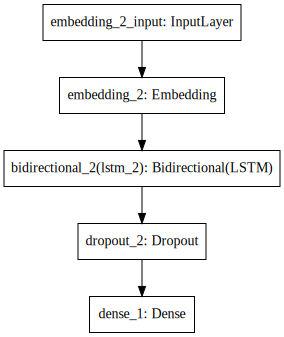

In [13]:
import pydot
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='lstm.png', show_shapes = True)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [125]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 256
file_path = "./lstm_model_20.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

import datetime
now1 = datetime.datetime.now()

history = model.fit(X, Y,
          validation_split=0.3, 
          # callbacks=[earlystopper],
          callbacks=[earlystopper, checkpoint],
          batch_size=batch_size, epochs=100, verbose = 1 
         )

now2 = datetime.datetime.now()

print()
print ("Start time : ")
print (now1.strftime("%Y-%m-%d %H:%M:%S"))
print ("Finish time : ")
print (now2.strftime("%Y-%m-%d %H:%M:%S"))

Train on 799848 samples, validate on 342792 samples
Epoch 1/100
799848/799848 [==============================] - 252s 315us/step - loss: 5.2890 - val_loss: 4.9244
Epoch 2/100
799848/799848 [==============================] - 248s 309us/step - loss: 4.6694 - val_loss: 4.6972
Epoch 3/100
799848/799848 [==============================] - 246s 307us/step - loss: 4.4649 - val_loss: 4.5776
Epoch 4/100
799848/799848 [==============================] - 247s 309us/step - loss: 4.3201 - val_loss: 4.5182
Epoch 5/100
799848/799848 [==============================] - 246s 307us/step - loss: 4.2060 - val_loss: 4.4800
Epoch 6/100
799848/799848 [==============================] - 248s 310us/step - loss: 4.1094 - val_loss: 4.4649
Epoch 7/100
799848/799848 [==============================] - 246s 308us/step - loss: 4.0250 - val_loss: 4.4668
Epoch 8/100
799848/799848 [==============================] - 246s 308us/step - loss: 3.9493 - val_loss: 4.4728
Epoch 9/100
799848/799848 [==============================] -

In [126]:
import pickle

with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

dict_keys(['val_loss', 'loss'])


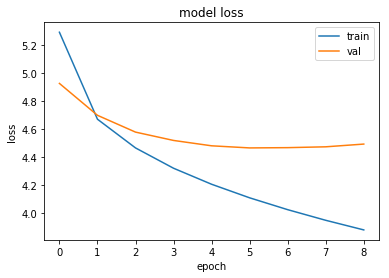

In [127]:
import matplotlib.pyplot as plt

# summarize history for loss
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Evaluate performance using Book 1

In [2]:
from keras.models import load_model

model_best = load_model('./lstm_model_20.hdf5')

import pickle

with open('./tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

len(tokenizer.word_index) + 1

/Users/qy/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


25274

In [5]:
with open('corpus_test/philosophers_stone.txt', 'r', encoding='latin-1"') as f:
    text_raw = f.readlines()

print(len(text_raw))   
text_all = " ".join(text_raw)
print(len(text_all))
text_in_words = clean_text(text_all)

input_len = 20
output_len = 20
n_words = 5000

STEP = 1
sentences = []
next_words = []

from nltk.tokenize import word_tokenize

corpus = word_tokenize(text_in_words)
token_list = tokenizer.texts_to_sequences([corpus])[0]
total_words = len(tokenizer.word_index) + 1

for i in range(0, len(token_list) - input_len - output_len, STEP):
    sentences.append(token_list[i: i + input_len])
    next_words.append(token_list[i + input_len])

print(len(sentences))
print(len(next_words))

import numpy as np
import pandas as pd
from keras.utils import to_categorical

X_test = np.array(sentences)
Y_test = to_categorical(next_words, num_classes=n_words)

print(X_test.shape)
print(Y_test.shape)

17
439463
88781
88781
(88781, 20)
(88781, 5000)


In [7]:
score = model_best.evaluate(X_test, Y_test, batch_size=256)
perplexity = np.power(2, score)
print("Loss: ", score)
print("Perplexity: ", perplexity)

88781/88781 [==============================] - 61s 687us/step
Loss:  4.38065548001175
Perplexity:  20.830931948834603
